# Question 1: Data Loading

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn import metrics
from scipy import io
import random

random.seed(2020)

data_mnist = io.loadmat("data/mnist_data.mat")
data_spam = io.loadmat("data/spam_data.mat")
data_cifar10 = io.loadmat("data/cifar10_data.mat")

In [ ]:
#
#
#
#
#
#
# 
#
#
# this is used to skip to a new page for the next question
#
#
#
#
#
#
#
# 
#
#
#
#

# Question 2: Data Partition

## Partitioning

In [30]:
def partition(data, val_set_size):
    training_data = data["training_data"]
    training_labels = data["training_labels"]
    
    # shuffle datasets before partition
    shuffle_index = random.sample(range(len(training_data)), 
                                        len(training_data))
    training_data = training_data[shuffle_index]
    training_labels = training_labels[shuffle_index]
    
    #partition data into training and validation set
    val_ind = random.sample(range(len(training_data)), val_set_size)
    val_x = training_data[val_ind]
    val_y = training_labels[val_ind]
    
    train_x = np.delete(training_data, val_ind, axis = 0)
    train_y = np.delete(training_labels, val_ind, axis = 0)
    return([train_x, train_y, val_x, val_y])

# (a) MNIST
[train_x_mnist, train_y_mnist, val_x_mnist, val_y_mnist] = partition(data_mnist, 10000)
# (b) spam
[train_x_spam, train_y_spam, val_x_spam, val_y_spam] = partition(data_spam, round(0.2 * len(data_spam["training_data"])))
# (c) CIFAR-10
[train_x_cifar, train_y_cifar, val_x_cifar, val_y_cifar] = partition(data_cifar10, 5000)

## Result

As we can see below, the three datasets (both X and the y labels) have been partitioned into training and validation set according to the specification of the question

In [31]:
print("(a)", len(val_x_mnist), len(val_y_mnist), len(train_x_mnist), len(train_y_mnist))
print("(b)", len(val_x_spam), len(val_y_spam), len(train_x_spam), len(train_y_spam))
print("(c)", len(val_x_cifar), len(val_y_cifar), len(train_x_cifar), len(train_y_cifar))

(a) 10000 10000 50000 50000
(b) 1034 1034 4138 4138
(c) 5000 5000 45000 45000


In [21]:
#
# this is used to skip to a new page for the next question
# 
#

# Question 3: Support Vector Machines

In [46]:
# define functions to be used in all three cases (MNIST, spam, CIFAR-10)

# function to compute training set accuracies given training sets of different size
def train_accr_vs_size(X_train, y_train, size_vec):
    accr = []
    for ex_size in size_vec:
        clf = svm.SVC(kernel = 'linear')
        clf.fit(X_train[range(ex_size)], y_train[range(ex_size)].ravel())
        y_pred = clf.predict(X_train[range(ex_size)])
        accr.append(metrics.accuracy_score(y_train[range(ex_size)], y_pred))
    return accr

# function to compute validation accuracies given training sets of different size
def val_accr_vs_size(X_train, y_train, X_pred, y_true, size_vec):
    accr = []
    for ex_size in size_vec:
        clf = svm.SVC(kernel = 'linear')
        clf.fit(X_train[range(ex_size)], y_train[range(ex_size)].ravel())
        y_pred = clf.predict(X_pred)
        accr.append(metrics.accuracy_score(y_true, y_pred))
    return accr

def plot_error(ex_size, train_error, val_error, data_name):
    plt.plot(ex_size, train_error, linestyle='dashed', marker='.',
             markersize=10, label = 'training error')
    plt.plot(ex_size, val_error, linestyle='dashed', marker='.',
             markersize=10, label = 'validation error')
    plt.title('Error Rate vs Example Size: ' + data_name)
    plt.legend()
    plt.xlabel('Training Example Size')
    plt.ylabel('Error Rate')

def calclt_and_plot(train_x, train_y, val_x, val_y, data_name, ex_size):
    train_accr = train_accr_vs_size(train_x, train_y, ex_size)
    train_error = [1 - x for x in train_accr]
    val_accr = val_accr_vs_size(train_x, train_y,
                                      val_x, val_y, ex_size)
    val_error = [1 - x for x in val_accr]
    plot_error(ex_size, train_error, val_error, data_name)

compute and plot the error rates vs. training example size

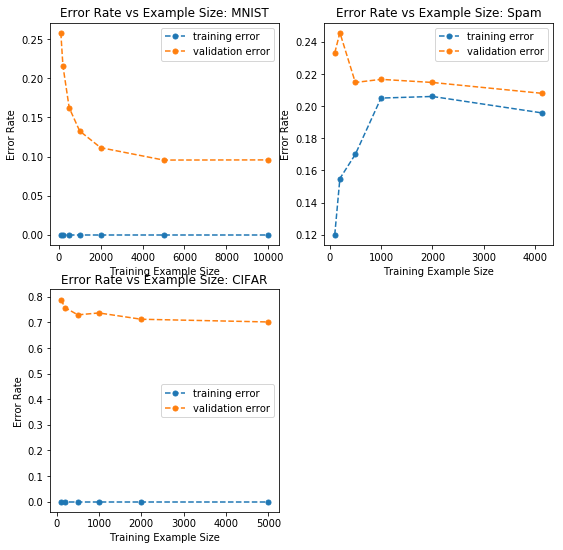

In [50]:
plt.figure(figsize=(9,9))
plt.subplot(221)
calclt_and_plot(train_x_mnist, train_y_mnist, val_x_mnist, val_y_mnist, "MNIST",
                [100, 200, 500, 1000, 2000, 5000, 10000])
plt.subplot(222)
calclt_and_plot(train_x_spam, train_y_spam, val_x_spam, val_y_spam, "Spam",
                [100, 200, 500, 1000, 2000, len(train_x_spam)])
plt.subplot(223)
calclt_and_plot(train_x_cifar, train_y_cifar, val_x_cifar, val_y_cifar, "CIFAR",
                [100, 200, 500, 1000, 2000, 5000])

In [1]:
#
# this is used to skip to a new page for the next question
# 
#

# Question 4: Hyperparameter Tuning

In [65]:
# set up a vector of C values to be experimented on. The values increase from
# 1e-10 to 1e10 by order of magnitude
C_vec = []
c0 = 1e-10
for i in range(21):
    C_vec.append(c0)
    c0 *= 10

# suppress unnecessary warnings when using LinearSVC
import warnings
warnings.filterwarnings("ignore")

# mnist validation
ex_index = random.sample(range(len(train_x_mnist)), 10000)
accr_vs_C_mnist = []
for i in C_vec:
    clf = svm.LinearSVC(C = i)
    clf.fit(train_x_mnist[ex_index], train_y_mnist[ex_index].ravel())
    y_pred = clf.predict(val_x_mnist)
    accr_vs_C_mnist.append(metrics.accuracy_score(val_y_mnist, y_pred))

accr_C_df_mnist = pd.DataFrame({'c value': C_vec, 'accuracies': accr_vs_C_mnist})
optimal_C_mnist = accr_C_df_mnist[accr_C_df_mnist["accuracies"]\
                            == max(accr_C_df_mnist["accuracies"])].iloc[0,0]

C values and corresponding accuracies with the best C being 1e-6

In [66]:
optimal_C_mnist

1e-06

In [67]:
accr_C_df_mnist

,c value,accuracies
0,1.000000e-10,0.7629
1,1.000000e-09,0.8304
2,1.000000e-08,0.8765
3,1.000000e-07,0.8966
4,1.000000e-06,0.8971
5,1.000000e-05,0.8847
6,1.000000e-04,0.8633
7,1.000000e-03,0.8423
8,1.000000e-02,0.8457
9,1.000000e-01,0.8423


In [2]:
#
#
#
#
#
#
# 
#
# 
#
#
#
#
#
#
#
# 
#
#
#
#
# this is used to skip to a new page for the next question
#
#
#
#
# 
#
#
#
#
#
#
#
#
#
# 
#
#

# Question 5: K-Fold Cross-Validation

In [57]:
train_data_spam = data_spam["training_data"]
train_labels_spam = data_spam["training_labels"]
n_spam = len(train_data_spam)
# shuffle the training data
shuffle_index = random.sample(range(n_spam), n_spam)
train_data_spam = train_data_spam[shuffle_index]
train_labels_spam = train_labels_spam[shuffle_index]

cv_accr_vs_C = [] # vector for average cv error over different C
for j in C_vec:
    accr_cv = [] # vector for the 5 cv errors given each C
    for i in range(5):
        # partition training data into 5 sets
        val_start_ind = round(i/5*n_spam)
        val_end_ind = round((i+1)/5*n_spam)
        val_set_X = train_data_spam[val_start_ind:val_end_ind]
        val_set_y = train_labels_spam[val_start_ind:val_end_ind]
        train_set_X = np.delete(train_data_spam, range(val_start_ind,val_end_ind), axis=0)
        train_set_y = np.delete(train_labels_spam, range(val_start_ind,val_end_ind), axis=0)
        # train the model using 4 of the 5 sets
        clf = svm.LinearSVC(C = j)
        clf.fit(train_set_X, train_set_y.ravel())
        # validate using the remaining 1 set
        y_pred = clf.predict(val_set_X)
        accr_cv.append(metrics.accuracy_score(val_set_y, y_pred))
    # the average of the 5 cv errors given this C
    cv_accr_vs_C.append(np.mean(accr_cv))

cv_accr_vs_C_df = pd.DataFrame({'c value': C_vec, 'accuracies': cv_accr_vs_C})
optimal_C_spam = cv_accr_vs_C_df[cv_accr_vs_C_df["accuracies"]\
                                 == max(cv_accr_vs_C_df["accuracies"])].iloc[0,0]

C values and corresponding accuracies with the best C being 10

In [58]:
optimal_C_spam

10.0

In [59]:
cv_accr_vs_C_df

,c value,accuracies
0,1.000000e-10,0.748069
1,1.000000e-09,0.748069
2,1.000000e-08,0.748069
3,1.000000e-07,0.748648
4,1.000000e-06,0.752515
5,1.000000e-05,0.760829
6,1.000000e-04,0.763536
7,1.000000e-03,0.778035
8,1.000000e-02,0.798724
9,1.000000e-01,0.802591


In [3]:
#
#
#
#
#
#
# 
#
# this is used to skip to a new page for the next question
#
#
#
#
#
#
#
# 
#
#
#
#

# Question6: Kaggle

## MNIST Prediction

In [60]:
training_data_mnist = data_mnist["training_data"]
training_labels_mnist = data_mnist["training_labels"]
test_data_mnist = data_mnist["test_data"]
clf = svm.SVC(C = optimal_C_mnist, kernel = 'linear') # optimal_C_mnist = 1e-6
clf.fit(training_data_mnist, training_labels_mnist.ravel())
y_test_pred_mnist = clf.predict(test_data_mnist)

## SPAM Prediction

In [ ]:
training_data_spam = data_spam["training_data"]
training_labels_spam = data_spam["training_labels"]
test_data_spam = data_spam["test_data"]
clf = svm.LinearSVC(C = optimal_C_spam) # optimal_C_spam = 10
clf.fit(training_data_spam, training_labels_spam.ravel())
y_test_pred_spam = clf.predict(test_data_spam)

## CIFAR-10 Prediction

### Hyperparameter Tuning for CIFAR-10
Since best C value for CIFAR-10 has not been found, find it first

In [4]:
# randomly select a training set of size 10000, find the best C according to
# performances on validation set
ex_index = random.sample(range(len(train_x_cifar)), 10000)
accr_vs_C_cifar = []
for i in C_vec:
    clf = svm.LinearSVC(C = i)
    clf.fit(train_x_cifar[ex_index], train_y_cifar[ex_index].ravel())
    y_pred = clf.predict(val_x_cifar)
    accr_vs_C_cifar.append(metrics.accuracy_score(val_y_cifar, y_pred))

accr_C_df_cifar = pd.DataFrame({'c value': C_vec, 'accuracies': accr_vs_C_cifar})
optimal_C_cifar = accr_C_df_cifar[accr_C_df_cifar["accuracies"]\
                            == max(accr_C_df_cifar["accuracies"])].iloc[0,0]


C values and corresponding accuracies with the best C being 1e-8

In [8]:
optimal_C_cifar

1e-08

In [7]:
accr_C_df_cifar

,c value,accuracies
0,1.000000e-10,0.3146
1,1.000000e-09,0.3614
2,1.000000e-08,0.3852
3,1.000000e-07,0.3726
4,1.000000e-06,0.3454
5,1.000000e-05,0.2866
6,1.000000e-04,0.2472
7,1.000000e-03,0.2630
8,1.000000e-02,0.2458
9,1.000000e-01,0.2368


### Prediction

In [ ]:
training_data_cifar10 = data_cifar10["training_data"]
training_labels_cifar10 = data_cifar10["training_labels"]
test_data_cifar10 = data_cifar10["test_data"]
clf = svm.LinearSVC(C = optimal_C_cifar) # optimal_C_cifar = 1e-8
clf.fit(training_data_cifar10, training_labels_cifar10.ravel())
y_test_pred_cifar10 = clf.predict(test_data_cifar10)

## write prediction into csv
comment and uncomment corresponding lines to write one of the three predictions into csv

In [62]:
def results_to_csv(y_test, filename):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(filename, index_label='Id')

results_to_csv(y_test_pred_mnist, 'submission_mnist.csv')
results_to_csv(y_test_pred_spam, 'submission_spam.csv')
results_to_csv(y_test_pred_cifar10, 'submission_cifar.csv')